# 资讯分析师

## 准备工作

pip安装 `akshare` 和 `langchain` 等必需的库：

In [1]:
%pip install --upgrade --quiet pandas akshare lark langchain-core langchain-openai langchain-community langchain-chroma langgraph

Note: you may need to restart the kernel to use updated packages.


获取股票主营介绍数据：

In [ ]:
import pandas as pd
import akshare as ak

# 沪深京 A 股实时行情数据
stock_zh_a_spot_em_df = ak.stock_zh_a_spot_em()
# 股票对应的主营介绍数据
stock_zyjs_ths_dfs = []
for stock_code, stock_name in zip(stock_zh_a_spot_em_df['代码'], stock_zh_a_spot_em_df['名称']):
    try:
        stock_zyjs_ths_df = ak.stock_zyjs_ths(stock_code)
        stock_zyjs_ths_df['股票名称'] = stock_name
        stock_zyjs_ths_dfs.append(stock_zyjs_ths_df)
    except Exception as e:
        print(f'Error processing stock {stock_code}: {e}')
        continue
stock_zyjs_ths_df = pd.concat(stock_zyjs_ths_dfs)
stock_zyjs_ths_df.to_csv('data/stock_zyjs_ths.csv', index=False, quoting=1)

加载股票主营介绍数据：

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    file_path='data/stock_zyjs_ths.csv',
    csv_args={
        'delimiter': ',',
        'quotechar': '"',
    },
    metadata_columns=['股票代码', '股票名称']
)

documents = loader.load()
print(f'Loaded {len(documents)} documents')

Loaded 5662 documents


embedding股票主营介绍数据并存储到向量数据库：

In [ ]:
import os
import pandas as pd

from langchain_openai import AzureOpenAIEmbeddings
from langchain_chroma import Chroma

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

ids = pd.read_csv('data/stock_zyjs_ths.csv')['股票代码'].astype(str).tolist()

for i in range(0, len(ids), 100):
    print(f'Adding documents {i} to {i+100}')
    partial_ids = ids[i:i+100]
    partial_documents = documents[i:i+100]
    # vector_store.add_documents(documents=partial_documents, ids=partial_ids)
    vector_store.update_documents(documents=partial_documents, ids=partial_ids)

## 资讯分析

初始化LLM模型和向量数据库：

In [31]:
import os

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_openai.chat_models.base import BaseChatOpenAI
from langchain_chroma import Chroma

llm = AzureChatOpenAI(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=1
)

# llm = BaseChatOpenAI(
#     model=os.environ['DEEPSEEK_MODEL_NAME'], 
#     openai_api_base=os.environ['DEEPSEEK_ENDPOINT'],
#     openai_api_key=os.environ['DEEPSEEK_API_KEY'], 
#     max_tokens=1024
# )


embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_EMBEDDING_API_VERSION'],
)

vector_store = Chroma(
    collection_name='stock_zyjs_ths',
    embedding_function=embeddings,
    persist_directory='data/verctor_store.db',
)

定义状态：

In [32]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.graph.message import add_messages

class State(TypedDict):
    news: str
    category: str
    messages: Annotated[list, add_messages]
    stocks: list[Document]
    report: str

定义获取财经新闻工具：

In [33]:
import akshare as ak

def get_financial_news(state: State):
    """Call the AkShare API to get the latest financial news."""
    stock_info_global_sina_df = ak.stock_info_global_sina()
    first_stock_info = stock_info_global_sina_df.iloc[0]['内容']
    return {
        'news': first_stock_info
    }


定义新闻分类节点:

In [34]:
from langchain_core.prompts import PromptTemplate

news_category_prompt_template = PromptTemplate.from_template('''你是一个财经新闻分类助手。
请根据以下财经新闻的内容，将其分类到适当的类别中。可用的类别包括：
1. 公司新闻
2. 行业动态
3. 市场趋势
4. 经济指标
5. 政策法规
如果无法确定分类，请输出“无法确定”。
以下是需要分类的财经新闻：
{news}
''')

get_news_category_chain = news_category_prompt_template | llm
def get_news_category(state: State):
    message = get_news_category_chain.invoke(state)
    return {
        'category': message.content
    }

定义公司新闻分析节点：

In [35]:
from langchain_core.prompts import PromptTemplate

company_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个公司新闻分析助手。
请根据以下公司新闻的内容，分析其对公司的影响。从以下几个方面进行分析：
1. 公司业务
2. 公司财务
3. 公司管理
4. 公司风险
5. 公司前景
以下是需要分析的公司新闻：
{news}
''')

get_company_news_analysis_chain = company_news_analysis_prompt_template | llm
def get_company_news_analysis(state: State):
    message = get_company_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义行业动态新闻分析节点：

In [36]:
from langchain_core.prompts import PromptTemplate

industry_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个行业新闻分析助手。
请根据以下行业新闻的内容，分析其对行业的影响。从以下几个方面进行分析：
1. 行业发展
2. 行业竞争
3. 行业政策
4. 行业前景
以下是需要分析的行业新闻：
{news}
''')

get_industry_news_analysis_chain = industry_news_analysis_prompt_template | llm
def get_industry_news_analysis(state: State):
    message = get_industry_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义市场趋势新闻分析节点：

In [37]:
from langchain_core.prompts import PromptTemplate

market_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个市场新闻分析助手。
请根据以下市场新闻的内容，分析其对市场的影响。从以下几个方面进行分析：
1. 市场趋势
2. 市场风险
3. 市场前景
以下是需要分析的市场新闻：
{news}
''')

get_market_news_analysis_chain = market_news_analysis_prompt_template | llm
def get_market_news_analysis(state: State):
    message = get_market_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义经济指标新闻分析节点：

In [38]:
from langchain_core.prompts import PromptTemplate

metrics_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个经济指标分析助手。
请根据以下经济指标的内容，分析其对经济的影响。从以下几个方面进行分析：
1. 经济增长
2. 通货膨胀
3. 就业情况
4. 利率水平
5. 汇率变动
以下是需要分析的经济指标新闻：
{news}
''')

get_metrics_news_analysis_chain = metrics_news_analysis_prompt_template | llm
def get_metrics_news_analysis(state: State):
    message = get_metrics_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义政策法规新闻分析节点：

In [39]:
from langchain_core.prompts import PromptTemplate

policy_news_analysis_prompt_template = PromptTemplate.from_template('''你是一个政策新闻分析助手。
请根据以下政策新闻的内容，分析其对政策的影响。从以下几个方面进行分析：
1. 政策内容
2. 政策目的
3. 政策影响
以下是需要分析的政策新闻：
{news}
''')

get_policy_news_analysis_chain = policy_news_analysis_prompt_template | llm
def get_policy_news_analysis(state: State):
    message = get_policy_news_analysis_chain.invoke(state)
    return {
        'messages': [message]
    }

定义无法确定分类的新闻节点：

In [40]:
from langchain_core.messages import AIMessage

def get_unknown_category_analysis(state: State):
    return {
        'messages': [AIMessage(content='暂无分析')]
    }

定义分析相关股票节点：

In [41]:
from langchain_core.prompts import PromptTemplate

stock_analysis_prompt_template = PromptTemplate.from_template('''你是一个专业的股票分析师。
请根据以下新闻内容，以及其他分析师对新闻的分析，分析可能受到影响的股票类型并给出原因
以下是新闻内容：
{news}
以下是其他分析师的分析：
{analysis}
''')

get_stock_analysis_chain = stock_analysis_prompt_template | llm
def get_stock_analysis(state: State):
    message = get_stock_analysis_chain.invoke({
        'news': state['news'],
        'analysis': state['messages'][-1].content
    })
    return {
        'messages': [message]
    }

定义检索器节点：

In [42]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name='股票代码',
        description='股票代码',
        type='string',
    ),
    AttributeInfo(
        name='股票名称',
        description='股票名称',
        type='integer',
    ),
]

document_content_description = '股票主营介绍'

retriever = SelfQueryRetriever.from_llm(
    llm,
    vector_store,
    document_content_description,
    metadata_field_info,
)

def search_stocks(state: State):
    messages = state['messages']
    stocks = retriever.invoke(messages[-1].content)
    return {
        'stocks': stocks
    }

定义输出报告节点：

In [43]:
def get_report(state: State):
    news = state['news']
    messages = state['messages']
    report = f'''最新财经新闻：{news}
新闻类别：{state['category']}
新闻分析报告：{messages[-2].content}
股票分析报告：{messages[-1].content}
股票列表：{', '.join([stock.metadata['股票名称'] for stock in state['stocks']])}
'''
    return {
        'report': report
    }

定义并编译图：

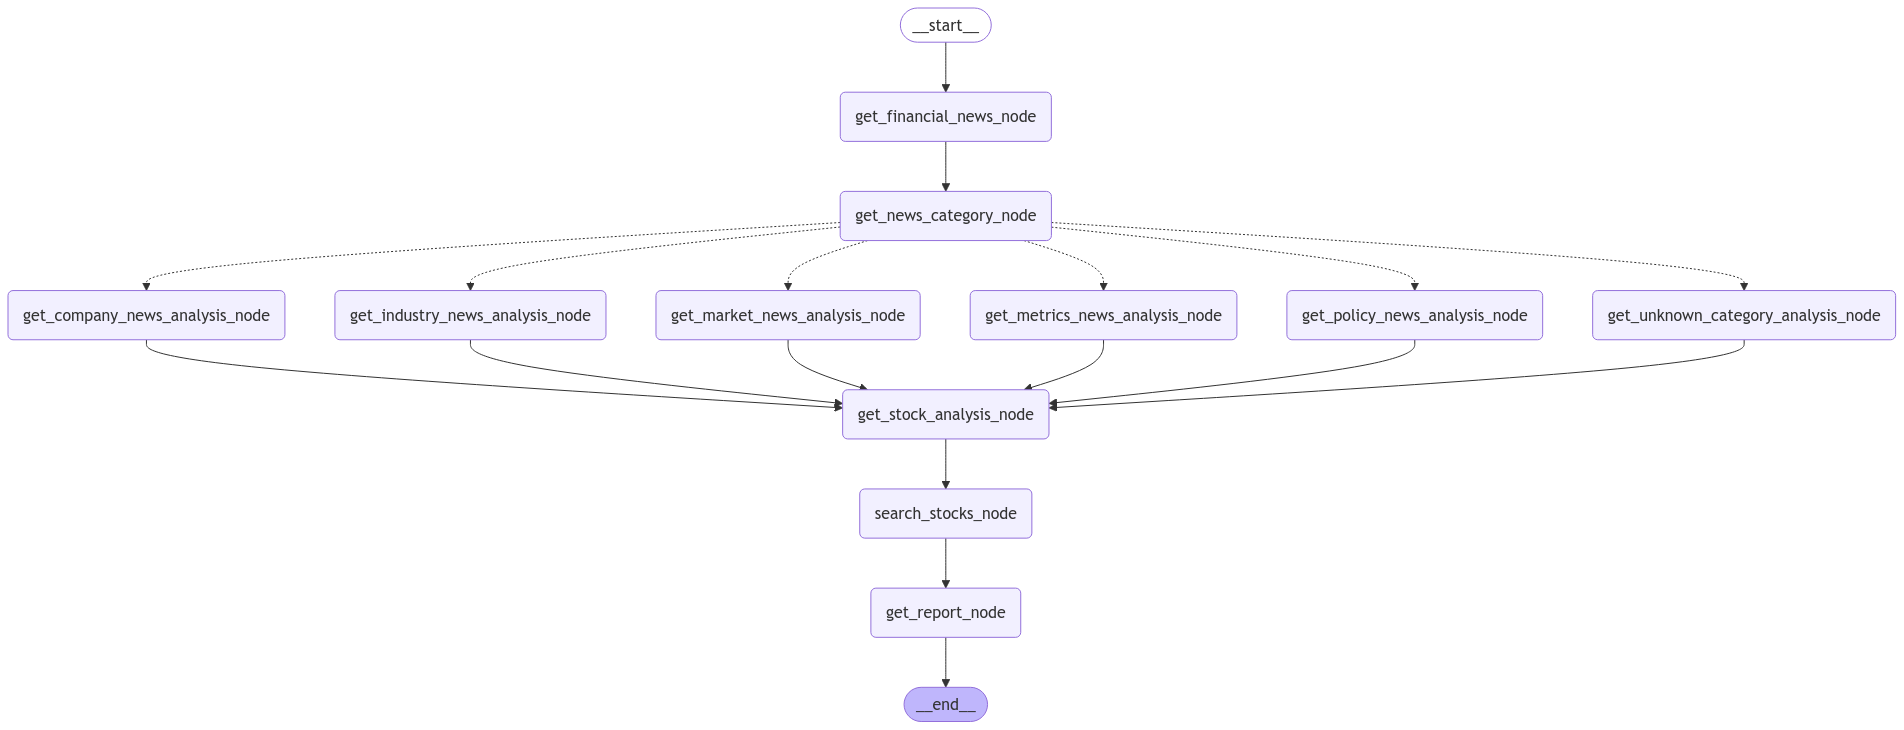

In [44]:
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display

set_llm_cache(InMemoryCache())

workflow = StateGraph(State)
news_category_nodes = ['get_company_news_analysis_node', 'get_industry_news_analysis_node', 'get_market_news_analysis_node', 'get_metrics_news_analysis_node', 'get_policy_news_analysis_node', 'get_unknown_category_analysis_node']
news_category_functions = [get_company_news_analysis, get_industry_news_analysis, get_market_news_analysis, get_metrics_news_analysis, get_policy_news_analysis, get_unknown_category_analysis]
workflow.add_node('get_financial_news_node', get_financial_news)
workflow.add_node('get_news_category_node', get_news_category)
for news_category_node, news_category_function in zip(news_category_nodes, news_category_functions):
    workflow.add_node(news_category_node, news_category_function)
workflow.add_node('get_stock_analysis_node', get_stock_analysis)
workflow.add_node('search_stocks_node', search_stocks)
workflow.add_node('get_report_node', get_report)

def route_news_category(state: State):
    category = state['category']
    if '公司新闻' in category:
        return ['get_company_news_analysis_node']
    elif '行业动态' in category:
        return ['get_industry_news_analysis_node']
    elif '市场趋势' in category:
        return ['get_market_news_analysis_node']
    elif '经济指标' in category:
        return ['get_metrics_news_analysis_node']
    elif '政策法规' in category:
        return ['get_policy_news_analysis_node']
    else:
        return ['get_unknown_category_analysis_node']

workflow.add_edge(START, 'get_financial_news_node')
workflow.add_edge('get_financial_news_node', 'get_news_category_node')
workflow.add_conditional_edges('get_news_category_node', route_news_category, news_category_nodes)
for news_category_node in news_category_nodes:
    workflow.add_edge(news_category_node, 'get_stock_analysis_node')
workflow.add_edge('get_stock_analysis_node', 'search_stocks_node')
workflow.add_edge('search_stocks_node', 'get_report_node')
workflow.add_edge('get_report_node', END)

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

display(Image(app.get_graph().draw_mermaid_png()))


执行图：

In [45]:
final_state = app.invoke(
    {'news': None, 'messages': [], 'stocks': [], 'report': None},
    config={'configurable': {'thread_id': 'information_analysis'}},
)

print(final_state['report'])

最新财经新闻：【中国贸促会新闻发言人就美方宣布对中国输美产品加征10%关税发表谈话】美国东部时间2月1日，美方以芬太尼等问题为由，对中国输美产品加征10％关税。中国工商界对此深表遗憾、坚决反对。美方单边加征关税的做法严重违反世贸组织规则，将使大量美国企业和消费者为此埋单，使中美正常经贸合作受到破坏，使全球产业链供应链稳定遭受冲击。贸易战、关税战没有赢家。美方的错误做法，不利于解决自身问题，不利于中美双边关系，不利于世界经济发展。我们强烈呼吁美方立即纠正错误做法，同中方相向而行，与各国加强合作，为两国乃至全球工商界实现互利共赢营造良好国际环境，为世界经济发展注入更多稳定性和正能量。
新闻类别：5. 政策法规
新闻分析报告：**1. 政策内容**

美国于东部时间2月1日宣布，基于芬太尼等问题，对中国输美产品加征10%的关税。这一关税措施涵盖了多种中国产品，采用单边行动的方式实施，对中国向美国的出口造成直接影响。

**2. 政策目的**

美国此举的主要目的是通过经济手段施压中国，解决长期以来存在的贸易不平衡、知识产权保护等问题。具体而言，针对芬太尼等议题，表明美国希望中国在相关领域加强监管和治理。此外，加征关税也是美国政府在当前国际贸易环境下，调整双边贸易关系、维护自身经济利益的一种策略手段，旨在促使中国在贸易政策和经济行为上作出让步。

**3. 政策影响**

**对中美双边关系的影响：**
- **经济层面**：加征关税将直接增加中国出口到美国产品的成本，可能导致中国产品在美国市场的竞争力下降，进而影响中国相关产业的生产和就业。同时，美国企业和消费者也将面临更高的采购成本，减少对中国产品的需求。
- **政治层面**：此举被中国视为单边主义和贸易保护主义的表现，可能加剧中美之间的贸易紧张关系，削弱双方在其他领域的合作基础，影响两国整体关系的稳定。

**对全球经济和产业链的影响：**
- **全球供应链**：中美作为全球最大的两个经济体，其贸易摩擦可能对全球供应链的稳定性产生负面影响，导致供应链重新调整，增加企业的经营成本和不确定性。
- **国际贸易规则**：美方单边加征关税的行为被中国指责为违反世贸组织规则，若持续，可能引发更多国家采取类似保护主义措施，削弱全球多边贸易体系的有效性，阻碍全球经济自由化和公平化进程。

**总结：**
此次美国对中国输美产品